In [2]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using Plots

import ProgressMeter
using Random

import Base: show
import PDMats: PDMat

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have LinearAlgebra in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added LinearAlgebra as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading LinearAlgebra into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


In [13]:
function hgf_timeslice(model, zt_prev, xt_prev, z_covariance, y_covariance, kfunction)
    
    zcov = add!(model, constvar(:zcov, z_covariance))
    zt   = add!(model, randomvar(:zt))
    
    z_transition = add!(model, make_node(MvNormalMeanCovariance{Float64}, zt_prev, zcov, zt, factorisation = ((1, 3),(2,))))
    
    xt = add!(model, randomvar(:xt))
    
    gcv = add!(model, make_node(KernelGCV, KernelGCVMetadata(kfunction, ghcubature(2)), xt_prev, zt, xt))
    
    ycov = add!(model, constvar(:ycov, y_covariance))
    y    = add!(model, datavar(:y, Vector{Float64}))
    
    obs = add!(model, make_node(MvNormalMeanCovariance{Float64}, xt, ycov, y))
    
    return (zt, xt, y, gcv, z_transition)
end

function hgf(n, iters, data, z_covariance, y_covariance, kfunction)
    model = Model(DefaultMessageGate())
    
    zs = Vector{RandomVariable}(undef, n)
    xs = Vector{RandomVariable}(undef, n)
    ys = Vector{DataVariable}(undef, n)
    
    zt_1_mean = add!(model, datavar(:zt_1_mean, Vector{Float64}))
    zt_1_cov  = add!(model, datavar(:zt_1_cov, PDMat{Float64, Matrix{Float64}}))
    zt_1      = add!(model, randomvar(:zt_1))
    
    xt_1_mean = add!(model, datavar(:xt_1_mean, Vector{Float64}))
    xt_1_cov  = add!(model, datavar(:xt_1_cov, PDMat{Float64, Matrix{Float64}}))
    xt_1      = add!(model, randomvar(:xt_1))
    
    zt_1_prior = add!(model, make_node(MvNormalMeanCovariance{Float64}, zt_1_mean, zt_1_cov, zt_1))
    xt_1_prior = add!(model, make_node(MvNormalMeanCovariance{Float64}, xt_1_mean, xt_1_cov, xt_1))    
    
    prev_zt_n = zt_1
    prev_xt_n = xt_1
    
    mz = Vector{MvNormalMeanCovariance}(undef, n)
    mx = Vector{MvNormalMeanCovariance}(undef, n)
    gcv = Vector{FactorNode}(undef, n)
    z_transition = Vector{FactorNode}(undef, n)
    
    mz_subs = Vector{Teardown}(undef, n)
    mx_subs = Vector{Teardown}(undef, n)
    
    ms_scheduler = PendingScheduler()

    for i in 1:n
        zt_n, xt_n, y_n, gcv_n, z_transition_n = hgf_timeslice(model, prev_zt_n, prev_xt_n, z_covariance, y_covariance, kfunction)
        
        zs[i] = zt_n
        xs[i] = xt_n
        ys[i] = y_n
        gcv[i] = gcv_n
        z_transition[i] = z_transition_n
        
        mz_subs[i] = subscribe!(getmarginal(zt_n) |> schedule_on(ms_scheduler), (t) -> mz[i] = getdata(t))
        mx_subs[i] = subscribe!(getmarginal(xt_n) |> schedule_on(ms_scheduler), (t) -> mx[i] = getdata(t))
    
        prev_zt_n = zt_n
        prev_xt_n = xt_n
    end
    
    activate!(model)
    
    foreach(gcv) do gcv_node
        setmarginal!(gcv_node, :x_y, MvNormalMeanCovariance([ 0.0, 0.0, 0.0, 0.0 ], PDMat(Matrix(Diagonal([ 5.0, 5.0, 5.0, 5.0 ])))))
        setmarginal!(gcv_node, :z, MvNormalMeanCovariance([ 0.0, 0.0 ], PDMat([ 5.0 0.0 ; 0.0 5.0 ])))
    end
    
    foreach(z_transition) do z_transition_node
        setmarginal!(z_transition_node, :mean_value, MvNormalMeanCovariance([ 0.0, 0.0, 0.0, 0.0 ], PDMat(Matrix(Diagonal([ 5.0, 5.0, 5.0, 5.0 ])))))
    end
    
    # Initial messages
    prior_zt = MvNormalMeanCovariance([ 0.0, 0.0 ], PDMat(Matrix(Diagonal([ 1.0, 1.0 ]))))
    prior_xt = MvNormalMeanCovariance([ 0.0, 0.0 ], PDMat(Matrix(Diagonal([ 1.0, 1.0 ]))))
    
    # fe = Vector{Float64}()
    
    fe_scheduler = PendingScheduler()
    # fe_sub = subscribe!(score(BetheFreeEnergy(), model, fe_scheduler), (d) -> push!(fe, d))
    
    ProgressMeter.@showprogress "inference" for _ in 1:iters
        update!(zt_1_mean, mean(prior_zt))
        update!(zt_1_cov, cov(prior_zt))
        update!(xt_1_mean, mean(prior_xt))
        update!(xt_1_cov, cov(prior_xt))

        for i in 1:n
            update!(ys[i], data[i])
        end
        
        release!(fe_scheduler)
    end
    
    release!(ms_scheduler)
 
    foreach(unsubscribe!, mz_subs)
    foreach(unsubscribe!, mx_subs)
    # unsubscribe!(fe_sub)
    
    return mz, mx
end

hgf (generic function with 1 method)

In [38]:
using Random
using Distributions
using LinearAlgebra

n = 1500
iters = 20

Random.seed!(223)

real_k = [ 1.0, 2.0 ]
real_w = [ -2.0, -1.0 ]

kfunction = (d) -> Diagonal(exp.(real_k .* d .+ real_w))

z_prev       = [ 0.0, 0.0 ]
z_covariance = PDMat([ 0.01 0.0; 0.0 0.01 ])

z = Vector{Vector{Float64}}(undef, n)
for i in 1:n
    z[i] = rand(MvNormal(z_prev, sqrt(Matrix(z_covariance))))
    z_prev = z[i]
end

# z = map(d -> 2.0 * sin(0.005 * d), 1:n)

v = map(d -> kfunction(d), z)

x_prev = [ 0.0, 0.0 ]

x = Vector{Vector{Float64}}(undef, n)

for i in 1:n
    x[i] = rand(MvNormal(x_prev, sqrt(v[i])))
    x_prev = x[i]
end

y = Vector{Vector{Float64}}(undef, n)
y_covariance = PDMat([ 1.0 0.0; 0.0 1.0 ])

for i in 1:n
    y[i] = rand(MvNormal(x[i], sqrt(Matrix(y_covariance))))
end

In [43]:
@time mz, mx = hgf(n, iters, y, z_covariance, y_covariance, kfunction);

inference100%|██████████████████████████████████████████| Time: 0:00:05


  5.995465 seconds (39.47 M allocations: 2.249 GiB, 19.67% gc time)


In [44]:
function plot_dimension(mz, mx, dim = 1)
    plot(map(d -> d[dim], mean.(mz)), ribbon = map(d -> sqrt(d[dim]), var.(mz)), label = :z)
    p1 = plot!(map(d -> d[dim], z), label = :real_z)

    plot(map(d -> d[dim], mean.(mx)), ribbon = map(d -> sqrt(d[dim]), var.(mx)), label = :x)
    p2 = plot!(map(d -> d[dim], x), label = :real_x)

    plot(p1, p2, layout = (2, 1), size = (800, 600))
end

plot_dimension (generic function with 2 methods)

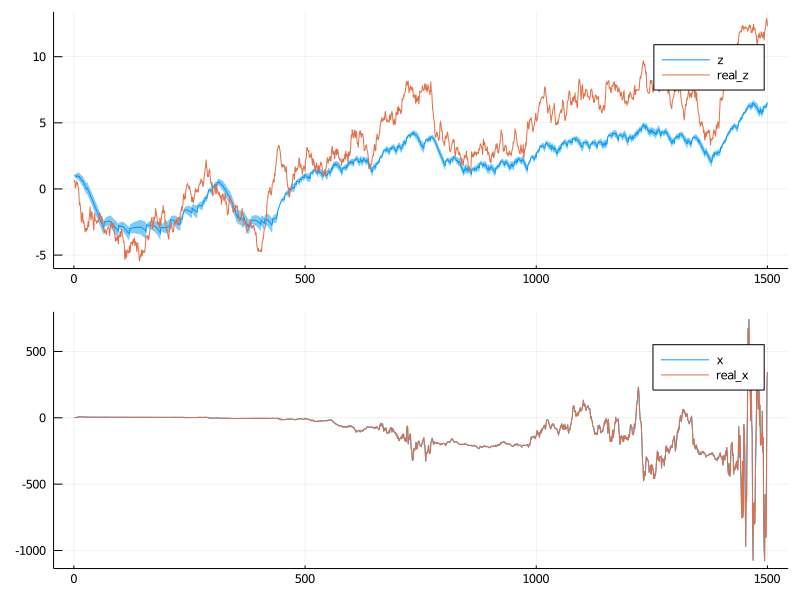

In [45]:
plot_dimension(mz, mx, 2)